In [1]:
import numpy as np
import nibabel as nb
import pandas as pd
import os.path as op
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from matplotlib.gridspec import GridSpec
import statsmodels.formula.api as smf
import moss
%matplotlib inline

In [2]:
home_dir = op.abspath('../')

#plotting settings
fontsize = 18
ticksize = fontsize*.8
sns.set_context('talk')
sns.__version__

'0.13.2'

In [3]:
pet = pd.read_csv('./csvs/pet.csv')

In [4]:
lags = pd.read_csv('./csvs/lags_pet_rois.csv')
lags = lags.rename(columns = {'mask':'roi'})
lags['sub'] = [int(x[2:]) for x in lags['sub']]
lags = lags[lags['sub'] != 216]
lags['lag'] = lags['lag']*1000


In [5]:
## genetic data
genes = pd.read_csv(op.abspath('./csvs/genes.csv'))[['sub','DRD2','COMT']]
genes = genes.groupby(['sub','COMT','DRD2']).mean().reset_index()

comt_map = {'Met':'Met/Met',
           'Val':'Val/Val'}
genes['COMT'] = [comt_map[x] for x in genes['COMT']]


lags = pd.merge(lags,
        genes,
         'left',
        on = 'sub')

In [6]:
#exclude bad subjects
lags = lags[lags['sub'] != 220]
lags = lags[lags['sub'] != 395]
len(set(lags['sub']))
len(set(lags['sub']))

73

In [7]:
#merge pet and lag data
for pet_id in ['fmt','rac','rac2']:
    
    fmt = pd.melt(pet,
           id_vars = ['sub'],
           value_vars = ['VST_' +pet_id,'DCA_' + pet_id,'DPUT_' +pet_id],
           value_name = pet_id)

    fmt['roi'] = [x.split('_')[0] for x in fmt['variable']]
    fmt = fmt[['sub',pet_id,'roi']]


    lags = pd.merge(fmt,
            lags,
            how = 'outer',
            on = ['sub','roi'])
lags = lags.dropna(subset = ['lag'])

In [8]:
lags = moss.remove_unit_variance(lags,'lag','sub', group = ['roi','DRD2','COMT'])

In [9]:
#rename columns
drug_map = {'plac':'Placebo','brom':'Bromocriptine','tolc':'Tolcapone'}
lags['Drug'] = [drug_map[x] for x in lags['drug']]
lags['dopamine synthesis capacity'] = lags['fmt']

roi_map = {'VST':'NAcc',
          'DCA':'Caudate',
          'DPUT':'Putamen',
          'S1':'S1',
          'OT':'OTC'}
lags[''] = [roi_map[x] for x in lags['roi']]

In [10]:
#compute delta on drugs
means = lags.groupby(['sub','DRD2','COMT','drug','roi'])['lag'].mean().reset_index()
means = means.set_index(['sub','roi']).sort_index()

means_df = []
for sub,roi in set(means.index):
    
    sub_df = means.loc[(sub,roi)].copy()
    
    brom_diff = float(sub_df.loc[sub_df['drug'] == 'brom','lag'] - sub_df.loc[sub_df['drug'] == 'plac','lag'])
    tolc_diff = float(sub_df.loc[sub_df['drug'] == 'tolc','lag'] - sub_df.loc[sub_df['drug'] == 'plac','lag'])
    
    means_df.append(pd.DataFrame({'sub':sub,
                                 'roi':roi_map[roi],
                                 'brom_diff':brom_diff,
                                  'tolc_diff':tolc_diff,
                                 'DRD2':sub_df['DRD2'].values[0],
                                 'COMT':sub_df['COMT'].values[0]},index = [0]))
means_df = pd.concat(means_df)

/var/folders/bn/dzh1ysw54m9cq4n3dnb30ldw0000gn/T/ipykernel_4494/3852835769.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  brom_diff = float(sub_df.loc[sub_df['drug'] == 'brom','lag'] - sub_df.loc[sub_df['drug'] == 'plac','lag'])
/var/folders/bn/dzh1ysw54m9cq4n3dnb30ldw0000gn/T/ipykernel_4494/3852835769.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  tolc_diff = float(sub_df.loc[sub_df['drug'] == 'tolc','lag'] - sub_df.loc[sub_df['drug'] == 'plac','lag'])


In [11]:
drug_diff = lags.sort_values(by = ['drug','sub','roi'])
drug_diff = drug_diff.set_index('drug')
drug_diff.loc['brom','lag_diff']= drug_diff.loc['brom','lag'].values -  drug_diff.loc['plac','lag'].values
drug_diff  = drug_diff.reset_index()

# Make figure

In [12]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

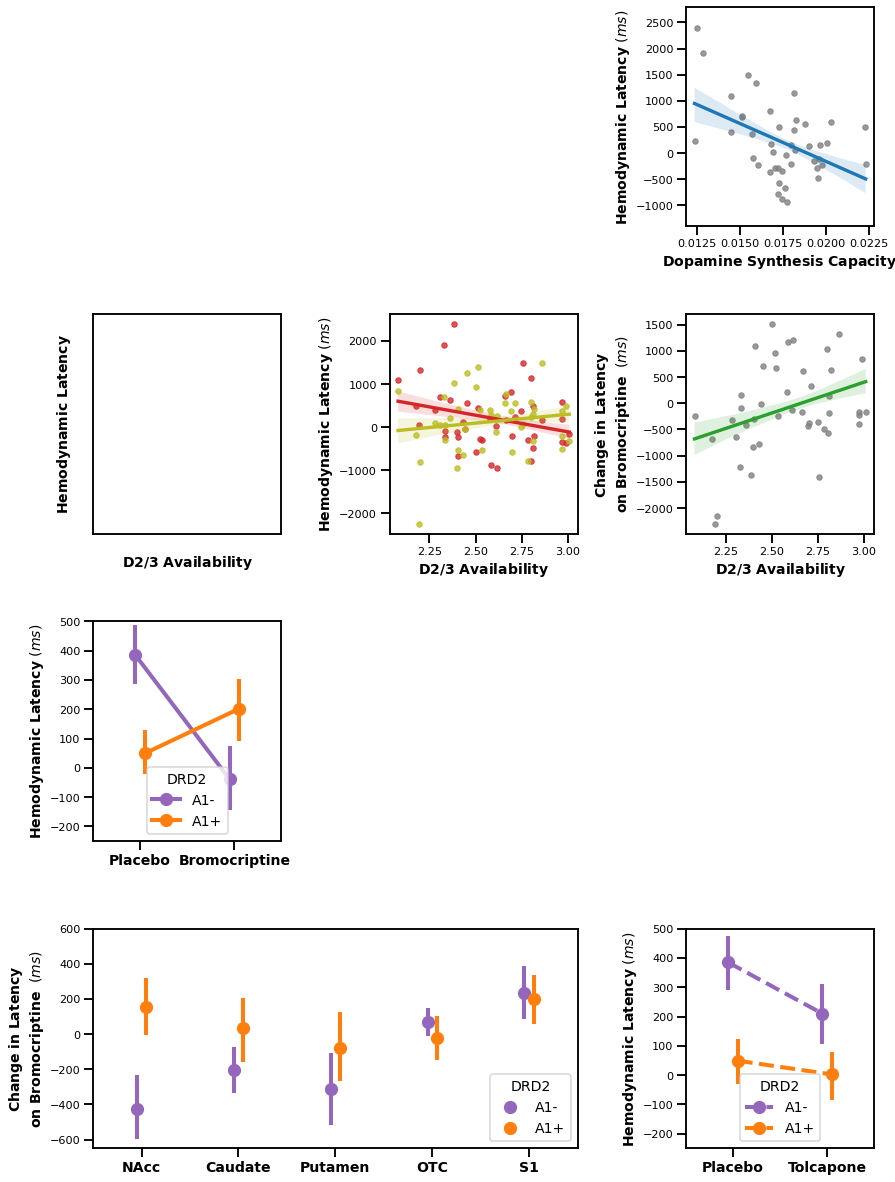

In [13]:
#plotting settings
fontsize = 14
ticksize = fontsize*.8
figy = 4
width = 16
sns.set_context('talk')
plt.rcParams['legend.title_fontsize'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize


fig = plt.figure(
                figsize=(14,21))#layout="constrained",
widths = [1,1,1,1,1,1]

gs = GridSpec(4, 6, 
              figure=fig,
              width_ratios=widths,
              hspace = .4,
              wspace = 2.7)

ax1 = fig.add_subplot(gs[0, 0:4])
ax2 = fig.add_subplot(gs[0, 4:])
ax3 = fig.add_subplot(gs[1, 0:2])
ax4 = fig.add_subplot(gs[1, 2:4])
ax5 = fig.add_subplot(gs[1, 4:])
ax6 = fig.add_subplot(gs[2, 0:2])
ax7 = fig.add_subplot(gs[2, 2:])
ax8 = fig.add_subplot(gs[3, 0:4])
ax9 = fig.add_subplot(gs[3, 4:])

for ax in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]:
    ax.tick_params(labelsize=ticksize)
    ax.xaxis.get_label().set_fontsize(fontsize)
    ax.yaxis.get_label().set_fontsize(fontsize)

    
##################
####Top Right######
##################
plac_df = lags[lags['Drug'] == 'Placebo']
vst_df = plac_df[plac_df['roi'] == 'VST']

sns.regplot(x = 'fmt',
             y = 'lag',
            scatter_kws={'s':30,
                       'color':'grey'},
            color = sns.color_palette()[0],
              ci = 68,
           ax = ax2,
             data=vst_df)
ax2.set(ylabel = '$\\bf{Hemodynamic\ Latency}$ $\it{(ms)}$',
            xlabel = '$\\bf{Dopamine\ Synthesis\ Capacity}$')
ax2.set_ylim([-1400, 2800])

##################
####Second Left######
##################
sns.regplot(x = 'rac',
             y = 'lag',
            scatter_kws={'s':30,
                         'alpha':.8,
                        'color':sns.color_palette()[3]},
            color = sns.color_palette()[3],
              ci = 68,
            ax = ax4,
             data=vst_df)

brom_df = lags[lags['Drug'] == 'Bromocriptine']
vst_df_brom = brom_df[brom_df['roi'] == 'VST']

sns.regplot(x = 'rac',
             y = 'lag',
            scatter_kws={'s':30,
                         'alpha':.8,
                        'color':sns.color_palette()[8]},
            color = sns.color_palette()[8],
              ci = 68,
            ax = ax4,
             data=vst_df_brom)

ax4.set(ylabel = '$\\bf{Hemodynamic\ Latency}$ $\it{(ms)}$',
            xlabel = '$\\bf{D2/3\ Availability}$')

##################
####Second Middle######
##################
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set(ylabel = '$\\bf{Hemodynamic\ Latency}$')
ax3.set(xlabel = '$\\bf{D2/3\ Availability}$')
ax3.xaxis.labelpad = 20
ax3.yaxis.labelpad = 20

##################
####Second Right######
##################
brom_df = drug_diff[drug_diff['Drug'] == 'Bromocriptine']
vst_df_diff = brom_df[brom_df['roi'] == 'VST']

sns.regplot(x = 'rac',
             y = 'lag_diff',
            scatter_kws={'s':30,
                       'color':'grey'},
            color = sns.color_palette()[2],
              ci = 68,
           ax = ax5,
             data=vst_df_diff)
ax5.set(ylabel = '$\\bf{Change\ in\ Latency}$\n$\\bf{on\ Bromocriptine\ }$ $\it{(ms)}$',
            xlabel = '$\\bf{D2/3\ Availability}$')

##################
####third Left######
##################
plac= lags[lags['drug'] != 'tolc']
plac= lags[lags['roi'] == 'VST']


sns.pointplot(x = 'Drug',
             y = 'lag_within',
              hue = 'DRD2',
            order = ['Placebo','Bromocriptine'],
              errorbar=('ci', 68),
              dodge = .1,
            palette = [sns.color_palette()[4],sns.color_palette()[1]],
                   ax = ax6,
             data=plac)

ax6.set(ylabel = '$\\bf{Hemodynamic\ Latency}$ $\it{(ms)}$',
            xlabel = '')
ax6.set_ylim([-250, 500])
ax6.tick_params(axis = 'x',
                    labelsize=fontsize)
ax6.xaxis.get_label().set_fontsize(ticksize)
labels = ax6.get_xticklabels()
for l in labels:
    l.set_fontweight('bold')
    l.set_fontsize(fontsize)

##################
####Top Right######
##################
sns.pointplot(x = 'roi',
             y = 'brom_diff',
             hue = 'DRD2',
              hue_order = ['A1-','A1+'],
              errorbar=('ci', 68),
              linestyle='none',
                          palette = [sns.color_palette()[4],sns.color_palette()[1]],
              order = ['NAcc','Caudate','Putamen','OTC','S1'],
              dodge = .1,
              ax = ax8,
             data = means_df)
ax8.set(ylabel = '$\\bf{Change\ in\ Latency}$\n$\\bf{on\ Bromocriptine\ }$ $\it{(ms)}$',
            xlabel = '')
ax8.tick_params(axis = 'x',
                    labelsize=fontsize)
ax8.set_ylim([-650, 600])

labels = ax8.get_xticklabels()
for l in labels:
    l.set_fontweight('bold')
    l.set_fontsize(fontsize)
    
##################
####Saving########
##################
plac= lags[lags['drug'] != 'brom']
plac= lags[lags['roi'] == 'VST']


sns.pointplot(x = 'Drug',
             y = 'lag_within',
              hue = 'DRD2',
            order = ['Placebo','Tolcapone'],
              errorbar=('ci', 68),
              linestyle = '--',
              dodge = .1,
            palette = [sns.color_palette()[4],sns.color_palette()[1]],
                   ax = ax9,
             data=plac)
ax9.set_ylim([-250, 500])

ax9.set(ylabel = '$\\bf{Hemodynamic\ Latency}$ $\it{(ms)}$',
            xlabel = '')
ax9.tick_params(axis = 'x',
                    labelsize=fontsize)
labels = ax9.get_xticklabels()
for l in labels:
    l.set_fontweight('bold')
    l.set_fontsize(fontsize)
        

ax1.axis('off')
ax7.axis('off')


plt.subplots_adjust(hspace = .7,
                   wspace= .7)
# plt.savefig('../figs/paper/fig2_figs.png',
#                             bbox_inches = 'tight',
#             dpi = 300)

In [14]:
model_lags = lags[lags['roi'] == 'VST'].dropna(subset = ['lag','DRD2'])

md = smf.mixedlm("lag ~ C(drug, Treatment('plac'))*C(DRD2,Sum)", model_lags, 
                 groups=model_lags["sub"]).fit()
md.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                 Mixed Linear Model Regression Results
========================================================================================================
Model:                             MixedLM                Dependent Variable:                lag        
No. Observations:                  207                    Method:                            REML       
No. Groups:                        69                     Scale:                             419217.7841
Min. group size:                   3                      Log-Likelihood:                    -1620.6312 
Max. group size:                   3                      Converged:                         Yes        
Mean group size:                   3.0                                                                  
--------------------------------------------------------------------------------------------------------
                                                         Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                                 217.056   88.968  2.440 0.015   42.682 391.429
C(drug, Treatment('plac'))[T.brom]                       -135.624  110.244 -1.230 0.219 -351.699  80.450
C(drug, Treatment('plac'))[T.tolc]                       -110.941  110.244 -1.006 0.314 -327.016 105.133
C(DRD2, Sum)[S.A1+]                                      -167.797   88.968 -1.886 0.059 -342.171   6.576
C(drug, Treatment('plac'))[T.brom]:C(DRD2, Sum)[S.A1+]    287.880  110.244  2.611 0.009   71.805 503.955
C(drug, Treatment('plac'))[T.tolc]:C(DRD2, Sum)[S.A1+]     63.988  110.244  0.580 0.562 -152.086 280.063
Group Var                                              126820.038   87.116                              
========================================================================================================

"""

In [15]:
model_lags = lags.dropna(subset = ['lag','DRD2']).copy()

md = smf.mixedlm("lag ~ C(drug, Treatment('plac'))*C(DRD2,Sum)*C(roi, Treatment('VST'))", model_lags, 
                 groups=model_lags["sub"]).fit()
md.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                  Mixed Linear Model Regression Results
==========================================================================================================================================
Model:                                       MixedLM                            Dependent Variable:                            lag        
No. Observations:                            1035                               Method:                                        REML       
No. Groups:                                  69                                 Scale:                                         412046.3176
Min. group size:                             15                                 Log-Likelihood:                                -8025.5012 
Max. group size:                             15                                 Converged:                                     Yes        
Mean group size:                             15.0                                                                                         
------------------------------------------------------------------------------------------------------------------------------------------
                                                                                          Coef.   Std.Err.   z    P>|z|   [0.025   0.975] 
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                 217.056   82.810  2.621 0.009    54.751  379.361
C(drug, Treatment('plac'))[T.brom]                                                       -135.624  109.297 -1.241 0.215  -349.843   78.594
C(drug, Treatment('plac'))[T.tolc]                                                       -110.941  109.297 -1.015 0.310  -325.160  103.277
C(DRD2, Sum)[S.A1+]                                                                      -167.797   82.810 -2.026 0.043  -330.103   -5.492
C(roi, Treatment('VST'))[T.DCA]                                                          -342.625  109.297 -3.135 0.002  -556.844 -128.407
C(roi, Treatment('VST'))[T.DPUT]                                                         -805.169  109.297 -7.367 0.000 -1019.387 -590.950
C(roi, Treatment('VST'))[T.OT]                                                           -188.304  109.297 -1.723 0.085  -402.522   25.915
C(roi, Treatment('VST'))[T.S1]                                                           -762.885  109.297 -6.980 0.000  -977.104 -548.666
C(drug, Treatment('plac'))[T.brom]:C(DRD2, Sum)[S.A1+]                                    287.880  109.297  2.634 0.008    73.661  502.098
C(drug, Treatment('plac'))[T.tolc]:C(DRD2, Sum)[S.A1+]                                     63.988  109.297  0.585 0.558  -150.230  278.207
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.DCA]                         52.980  154.570  0.343 0.732  -249.971  355.931
C(drug, Treatment('plac'))[T.tolc]:C(roi, Treatment('VST'))[T.DCA]                        -99.742  154.570 -0.645 0.519  -402.692  203.209
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.DPUT]                       -59.904  154.570 -0.388 0.698  -362.855  243.047
C(drug, Treatment('plac'))[T.tolc]:C(roi, Treatment('VST'))[T.DPUT]                       -54.547  154.570 -0.353 0.724  -357.498  248.404
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.OT]                         159.550  154.570  1.032 0.302  -143.401  462.501
C(drug, Treatment('plac'))[T.tolc]:C(roi, Treatment('VST'))[T.OT]                          24.666  154.570  0.160 0.873  -278.285  327.617
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.S1]                         353.998  154.570  2.290 0.022    51.047  656.949
C(drug, Treatment('plac'))[T.tolc]:C(roi, Treatment('VST'))[T.S1]                         304.528  154.570  1.

## COMT

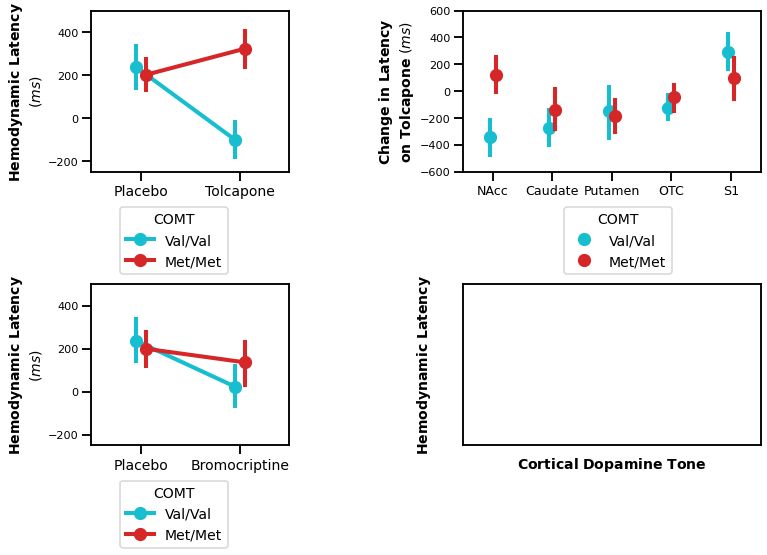

In [16]:
#plotting settings
fontsize = 14
ticksize = fontsize*.8
figy = 4
width = 16
sns.set_context('talk')
plt.rcParams['legend.title_fontsize'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize


fig,ax=plt.subplots(2,2,
                    figsize=(12,8),
                    width_ratios=[1, 1.5],
                    sharex=False,
                    sharey=False)
for i in range(2):
    for j in range(2):
        ax[i][j].tick_params(labelsize=ticksize)
        ax[i][j].xaxis.get_label().set_fontsize(fontsize)
        ax[i][j].yaxis.get_label().set_fontsize(fontsize)

##################
####Top Left######
##################
plac= lags[lags['drug'] != 'tolc']
plac= lags[lags['roi'] == 'VST']


sns.pointplot(x = 'Drug',
             y = 'lag_within',
              hue = 'COMT',
            order = ['Placebo','Tolcapone'],
                          hue_order = ['Val/Val','Met/Met'],
              errorbar=('ci', 68),
              dodge = .1,
            palette = [sns.color_palette()[9],sns.color_palette()[3]],
                   ax = ax[0][0],
             data=plac)
ax[0,0].set_ylim([-250, 500])
ax[0][0].set(ylabel = '$\\bf{Hemodynamic\ Latency}$\n$\it{(ms)}$',
            xlabel = '')
ax[0][0].tick_params(axis = 'x',
                    labelsize=fontsize)
ax[0][0].xaxis.get_label().set_fontsize(ticksize)
sns.move_legend(ax[0][0], "upper right",bbox_to_anchor=(.725,-.175))


##################
####Top Right######
##################
sns.pointplot(x = 'roi',
             y = 'tolc_diff',
             hue = 'COMT',
              errorbar=('ci', 68),
              linestyle='none',
                            hue_order = ['Val/Val','Met/Met'],
            palette = [sns.color_palette()[9],sns.color_palette()[3]],
              order = ['NAcc','Caudate','Putamen','OTC','S1'],
              dodge = .1,
              ax = ax[0][1],
             data = means_df)
ax[0][1].set(ylabel = '$\\bf{Change\ in\ Latency}$\n$\\bf{on\ Tolcapone\ }$$\it{(ms)}$',
            xlabel = '')
ax[0][1].tick_params(axis = 'x',
                    labelsize=fontsize*.9)
ax[0,1].set_ylim([-600, 600])
sns.move_legend(ax[0][1], "upper right",bbox_to_anchor=(.725,-.175))




##################
####Bottom Left####
##################
plac= lags[lags['drug'] != 'tolc']
plac= lags[lags['roi'] == 'VST']
sns.pointplot(x = 'Drug',
             y = 'lag_within',
              hue = 'COMT',
              hue_order = ['Val/Val','Met/Met'],
            order = ['Placebo','Bromocriptine'],
              errorbar=('ci', 68),
              dodge = .1,
            palette = [sns.color_palette()[9],sns.color_palette()[3]],
                   ax = ax[1][0],
             data=plac)

ax[1][0].set(ylabel = '$\\bf{Hemodynamic\ Latency}$\n$\it{(ms)}$',
            xlabel = '')
ax[1][0].tick_params(axis = 'x',
                    labelsize=fontsize)
ax[1][0].xaxis.get_label().set_fontsize(ticksize)
sns.move_legend(ax[1][0], "upper right",bbox_to_anchor=(.725,-.175))
ax[1,0].set_ylim([-250, 500])


ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
ax[1,1].set(ylabel = '$\\bf{Hemodynamic\ Latency}$')
ax[1,1].set(xlabel = '$\\bf{Cortical\ Dopamine\ Tone}$')
ax[1,1].yaxis.labelpad = 30
ax[1,1].xaxis.labelpad = 10
##################
####Saving########
##################

plt.subplots_adjust(hspace = .7,
                   wspace= .7)
# plt.savefig('../figs/paper/fig2_figs_Supplement.png',
#                             bbox_inches = 'tight',
#             dpi = 300)

In [17]:
model_lags = lags[lags['roi'] == 'VST'].dropna(subset = ['lag','COMT'])

md = smf.mixedlm("lag ~ C(drug, Treatment('plac'))*C(COMT,Sum)", model_lags, 
                 groups=model_lags["sub"]).fit()
md.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Mixed Linear Model Regression Results
============================================================================================================
Model:                             MixedLM                  Dependent Variable:                  lag        
No. Observations:                  207                      Method:                              REML       
No. Groups:                        69                       Scale:                               428524.9231
Min. group size:                   3                        Log-Likelihood:                      -1621.5349 
Max. group size:                   3                        Converged:                           Yes        
Mean group size:                   3.0                                                                      
------------------------------------------------------------------------------------------------------------
                                                             Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                                     219.214   89.108  2.460 0.014   44.565 393.863
C(drug, Treatment('plac'))[T.brom]                           -138.705  111.461 -1.244 0.213 -357.166  79.755
C(drug, Treatment('plac'))[T.tolc]                           -108.528  111.461 -0.974 0.330 -326.989 109.932
C(COMT, Sum)[S.Met/Met]                                       -18.874   89.108 -0.212 0.832 -193.523 155.775
C(drug, Treatment('plac'))[T.brom]:C(COMT, Sum)[S.Met/Met]     75.282  111.461  0.675 0.499 -143.178 293.742
C(drug, Treatment('plac'))[T.tolc]:C(COMT, Sum)[S.Met/Met]    230.483  111.461  2.068 0.039   12.023 448.944
Group Var                                                  119239.548   84.716                              
============================================================================================================

"""

In [18]:
model_lags = lags[lags['roi'] == 'VST'].dropna(subset = ['lag','COMT'])

md = smf.mixedlm("lag ~ C(drug, Treatment('plac'))*C(COMT,Sum) + C(drug, Treatment('plac'))*C(DRD2,Sum)", model_lags, 
                 groups=model_lags["sub"]).fit()
md.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Mixed Linear Model Regression Results
============================================================================================================
Model:                             MixedLM                  Dependent Variable:                  lag        
No. Observations:                  207                      Method:                              REML       
No. Groups:                        69                       Scale:                               411131.8111
Min. group size:                   3                        Log-Likelihood:                      -1601.2867 
Max. group size:                   3                        Converged:                           Yes        
Mean group size:                   3.0                                                                      
------------------------------------------------------------------------------------------------------------
                                                             Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                                     216.820   88.266  2.456 0.014   43.822 389.819
C(drug, Treatment('plac'))[T.brom]                           -134.607  109.187 -1.233 0.218 -348.610  79.395
C(drug, Treatment('plac'))[T.tolc]                           -107.661  109.187 -0.986 0.324 -321.664 106.341
C(COMT, Sum)[S.Met/Met]                                       -16.480   88.266 -0.187 0.852 -189.479 156.518
C(DRD2, Sum)[S.A1+]                                          -167.562   88.266 -1.898 0.058 -340.560   5.437
C(drug, Treatment('plac'))[T.brom]:C(COMT, Sum)[S.Met/Met]     71.184  109.187  0.652 0.514 -142.819 285.187
C(drug, Treatment('plac'))[T.tolc]:C(COMT, Sum)[S.Met/Met]    229.616  109.187  2.103 0.035   15.614 443.619
C(drug, Treatment('plac'))[T.brom]:C(DRD2, Sum)[S.A1+]        286.863  109.187  2.627 0.009   72.860 500.866
C(drug, Treatment('plac'))[T.tolc]:C(DRD2, Sum)[S.A1+]         60.708  109.187  0.556 0.578 -153.294 274.711
Group Var                                                  126218.620   87.537                              
============================================================================================================

"""

In [19]:
model_lags = lags.dropna(subset = ['lag','COMT']).copy()

md = smf.mixedlm("lag ~ C(drug, Treatment('plac'))*C(COMT,Sum)*C(roi, Treatment('VST'))", model_lags, 
                 groups=model_lags["sub"]).fit()
md.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                    Mixed Linear Model Regression Results
==============================================================================================================================================
Model:                                         MixedLM                             Dependent Variable:                             lag        
No. Observations:                              1035                                Method:                                         REML       
No. Groups:                                    69                                  Scale:                                          411293.6465
Min. group size:                               15                                  Log-Likelihood:                                 -8024.2816 
Max. group size:                               15                                  Converged:                                      Yes        
Mean group size:                               15.0                                                                                           
----------------------------------------------------------------------------------------------------------------------------------------------
                                                                                              Coef.   Std.Err.   z    P>|z|   [0.025   0.975] 
----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                     219.214   82.665  2.652 0.008    57.193  381.235
C(drug, Treatment('plac'))[T.brom]                                                           -138.705  109.197 -1.270 0.204  -352.728   75.317
C(drug, Treatment('plac'))[T.tolc]                                                           -108.528  109.197 -0.994 0.320  -322.551  105.494
C(COMT, Sum)[S.Met/Met]                                                                       -18.874   82.665 -0.228 0.819  -180.895  143.147
C(roi, Treatment('VST'))[T.DCA]                                                              -343.811  109.197 -3.149 0.002  -557.833 -129.788
C(roi, Treatment('VST'))[T.DPUT]                                                             -804.580  109.197 -7.368 0.000 -1018.603 -590.557
C(roi, Treatment('VST'))[T.OT]                                                               -191.870  109.197 -1.757 0.079  -405.893   22.153
C(roi, Treatment('VST'))[T.S1]                                                               -765.311  109.197 -7.009 0.000  -979.334 -551.289
C(drug, Treatment('plac'))[T.brom]:C(COMT, Sum)[S.Met/Met]                                     75.282  109.197  0.689 0.491  -138.741  289.305
C(drug, Treatment('plac'))[T.tolc]:C(COMT, Sum)[S.Met/Met]                                    230.483  109.197  2.111 0.035    16.461  444.506
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.DCA]                             54.617  154.428  0.354 0.724  -248.057  357.291
C(drug, Treatment('plac'))[T.tolc]:C(roi, Treatment('VST'))[T.DCA]                           -100.926  154.428 -0.654 0.513  -403.600  201.748
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.DPUT]                           -56.172  154.428 -0.364 0.716  -358.846  246.503
C(drug, Treatment('plac'))[T.tolc]:C(roi, Treatment('VST'))[T.DPUT]                           -60.149  154.428 -0.389 0.697  -362.823  242.525
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.OT]                             165.326  154.428  1.071 0.284  -137.348  468.000
C(drug, Treatment('plac'))[T.tolc]:C(roi, Treatment('VST'))[T.OT]                              22.669  154.428  0.147 0.883  -280.005  325.343
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.S1]                             353.846  154.428  2.291 0.022    51.172  656.520


In [20]:
# model_lags = lags.dropna(subset = ['fmt'])
model_lags = lags[lags['drug'] != 'tolc'].dropna(subset = ['fmt'])

model_lags['fmt'] = model_lags['fmt'] - np.mean(model_lags['fmt'])        
md = smf.mixedlm("lag ~ C(drug, Treatment('plac'))*C(roi,Treatment('VST'))*fmt", model_lags, 
                 groups=model_lags["sub"]).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                              Mixed Linear Model Regression Results
=================================================================================================================================
Model:                                    MixedLM                         Dependent Variable:                         lag        
No. Observations:                         264                             Method:                                     REML       
No. Groups:                               44                              Scale:                                      411282.2480
Min. group size:                          6                               Log-Likelihood:                             -1999.6737 
Max. group size:                          6                               Converged:                                  Yes        
Mean group size:                          6.0                                                                                    
---------------------------------------------------------------------------------------------------------------------------------
                                                                           Coef.     Std.Err.   z    P>|z|    [0.025     0.975]  
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                  -215.741   186.058 -1.160 0.246    -580.408    148.926
C(drug, Treatment('plac'))[T.brom]                                           99.113   224.250  0.442 0.659    -340.409    538.634
C(roi, Treatment('VST'))[T.DCA]                                             204.188   198.046  1.031 0.303    -183.976    592.352
C(roi, Treatment('VST'))[T.DPUT]                                           -542.789   309.222 -1.755 0.079   -1148.853     63.275
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.DCA]         -422.691   272.638 -1.550 0.121    -957.052    111.670
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.DPUT]         250.267   361.845  0.692 0.489    -458.936    959.471
fmt                                                                     -152386.192 50989.707 -2.989 0.003 -252324.181 -52448.203
C(drug, Treatment('plac'))[T.brom]:fmt                                    66569.639 62462.427  1.066 0.287  -55854.469 188993.746
C(roi, Treatment('VST'))[T.DCA]:fmt                                      230414.854 66931.622  3.443 0.001   99231.285 361598.424
C(roi, Treatment('VST'))[T.DPUT]:fmt                                     190588.367 63841.777  2.985 0.003   65460.783 315715.952
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.DCA]:fmt  -268054.845 93481.749 -2.867 0.004 -451275.707 -84833.983
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.DPUT]:fmt -197400.880 89332.843 -2.210 0.027 -372490.035 -22311.725
Group Var                                                                185538.448    95.135                                    
=================================================================================================================================

"""

In [21]:
model_lags = lags[lags['drug'] != 'tolc'].dropna(subset = ['rac'])

model_lags['rac'] = model_lags['rac'] - np.mean(model_lags['rac'])        
md = smf.mixedlm("lag ~ C(drug, Treatment('plac'))*C(roi,Treatment('VST'))*rac", model_lags, 
                 groups=model_lags["sub"]).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                           Mixed Linear Model Regression Results
===========================================================================================================================
Model:                                  MixedLM                       Dependent Variable:                       lag        
No. Observations:                       264                           Method:                                   REML       
No. Groups:                             44                            Scale:                                    444404.2381
Min. group size:                        6                             Log-Likelihood:                           -2037.0749 
Max. group size:                        6                             Converged:                                Yes        
Mean group size:                        6.0                                                                                
---------------------------------------------------------------------------------------------------------------------------
                                                                          Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                                 -213.916  276.747 -0.773 0.440  -756.329  328.498
C(drug, Treatment('plac'))[T.brom]                                         554.360  349.180  1.588 0.112  -130.021 1238.741
C(roi, Treatment('VST'))[T.DCA]                                            166.037  285.260  0.582 0.561  -393.062  725.136
C(roi, Treatment('VST'))[T.DPUT]                                          -475.790  430.838 -1.104 0.269 -1320.217  368.637
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.DCA]        -703.964  384.634 -1.830 0.067 -1457.833   49.905
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.DPUT]       -542.117  524.912 -1.033 0.302 -1570.926  486.692
rac                                                                       -787.781  455.569 -1.729 0.084 -1680.679  105.117
C(drug, Treatment('plac'))[T.brom]:rac                                    1176.135  581.876  2.021 0.043    35.679 2316.591
C(roi, Treatment('VST'))[T.DCA]:rac                                       1088.219  554.713  1.962 0.050     1.002 2175.436
C(roi, Treatment('VST'))[T.DPUT]:rac                                       902.094  570.343  1.582 0.114  -215.758 2019.947
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.DCA]:rac   -1425.151  767.897 -1.856 0.063 -2930.201   79.899
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.DPUT]:rac  -1422.786  781.395 -1.821 0.069 -2954.292  108.719
Group Var                                                               181812.554   92.481                                
===========================================================================================================================

"""

In [22]:
model_lags = lags[lags['roi'] == 'VST'].dropna(subset = ['rac2'])

model_lags['rac2'] = model_lags['rac2'] - np.mean(model_lags['rac2'])  

md = smf.mixedlm("lag ~ C(drug, Treatment('plac'))*rac2", model_lags, 
                 groups=model_lags["sub"]).fit()
md.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Mixed Linear Model Regression Results
=========================================================================================
Model:                        MixedLM           Dependent Variable:           lag        
No. Observations:             132               Method:                       REML       
No. Groups:                   44                Scale:                        398250.1978
Min. group size:              3                 Log-Likelihood:               -1022.3069 
Max. group size:              3                 Converged:                    Yes        
Mean group size:              3.0                                                        
-----------------------------------------------------------------------------------------
                                          Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------------------------------------
Intercept                                  217.894  111.612  1.952 0.051   -0.862 436.650
C(drug, Treatment('plac'))[T.brom]         -90.320  134.545 -0.671 0.502 -354.023 173.383
C(drug, Treatment('plac'))[T.tolc]        -279.615  134.545 -2.078 0.038 -543.318 -15.913
rac2                                        -0.666   30.166 -0.022 0.982  -59.791  58.459
C(drug, Treatment('plac'))[T.brom]:rac2    -43.295   36.365 -1.191 0.234 -114.568  27.978
C(drug, Treatment('plac'))[T.tolc]:rac2     -0.282   36.365 -0.008 0.994  -71.555  70.991
Group Var                               149872.311  119.695                              
=========================================================================================

"""